# **Neural Network-Based Image Description Generation**: 
## Image Captioning with Bahdanau Attention and Resnet50, LSTM

In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('C:/Users/User/PycharmProjects/Captioning/venv/dataset_dir'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = 'C:/Users/User/PycharmProjects/Captioning/venv/dataset_dir'
WORKING_DIR = 'C:/Users/User/PycharmProjects/Captioning/venv'

In [ ]:
# Load ResNet50 model 
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


# Restructure the model to extract feature vectors
model = Model(inputs=model.input, outputs=model.output)

# Summarize the model
print(model.summary())


In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

In [ ]:
FEATURES_PATH = os.path.join(WORKING_DIR, 'resnet50_features.pkl')

# Check if features file already exists
if os.path.exists(FEATURES_PATH):
    print("Loading pre-extracted features...")
    with open(FEATURES_PATH, 'rb') as f:
        features = pickle.load(f)
else:
    print("Extracting features using ResNet50...")
    features = {}
    
    for img_name in tqdm(os.listdir(directory)):
        # Load and preprocess image
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)  # Reshape for model
        image = preprocess_input(image)  # Apply ResNet preprocessing
        
        # Extract features using ResNet50
        feature = model.predict(image, verbose=0)
        
        # Store feature
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    
    # Save extracted features to a pickle file
    print("Saving extracted features...")
    with open(FEATURES_PATH, 'wb') as f:
        pickle.dump(features, f)


In [7]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'resnet50_features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'resnet50_features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
len(mapping)

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

In [14]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

In [ ]:
all_captions[:10]

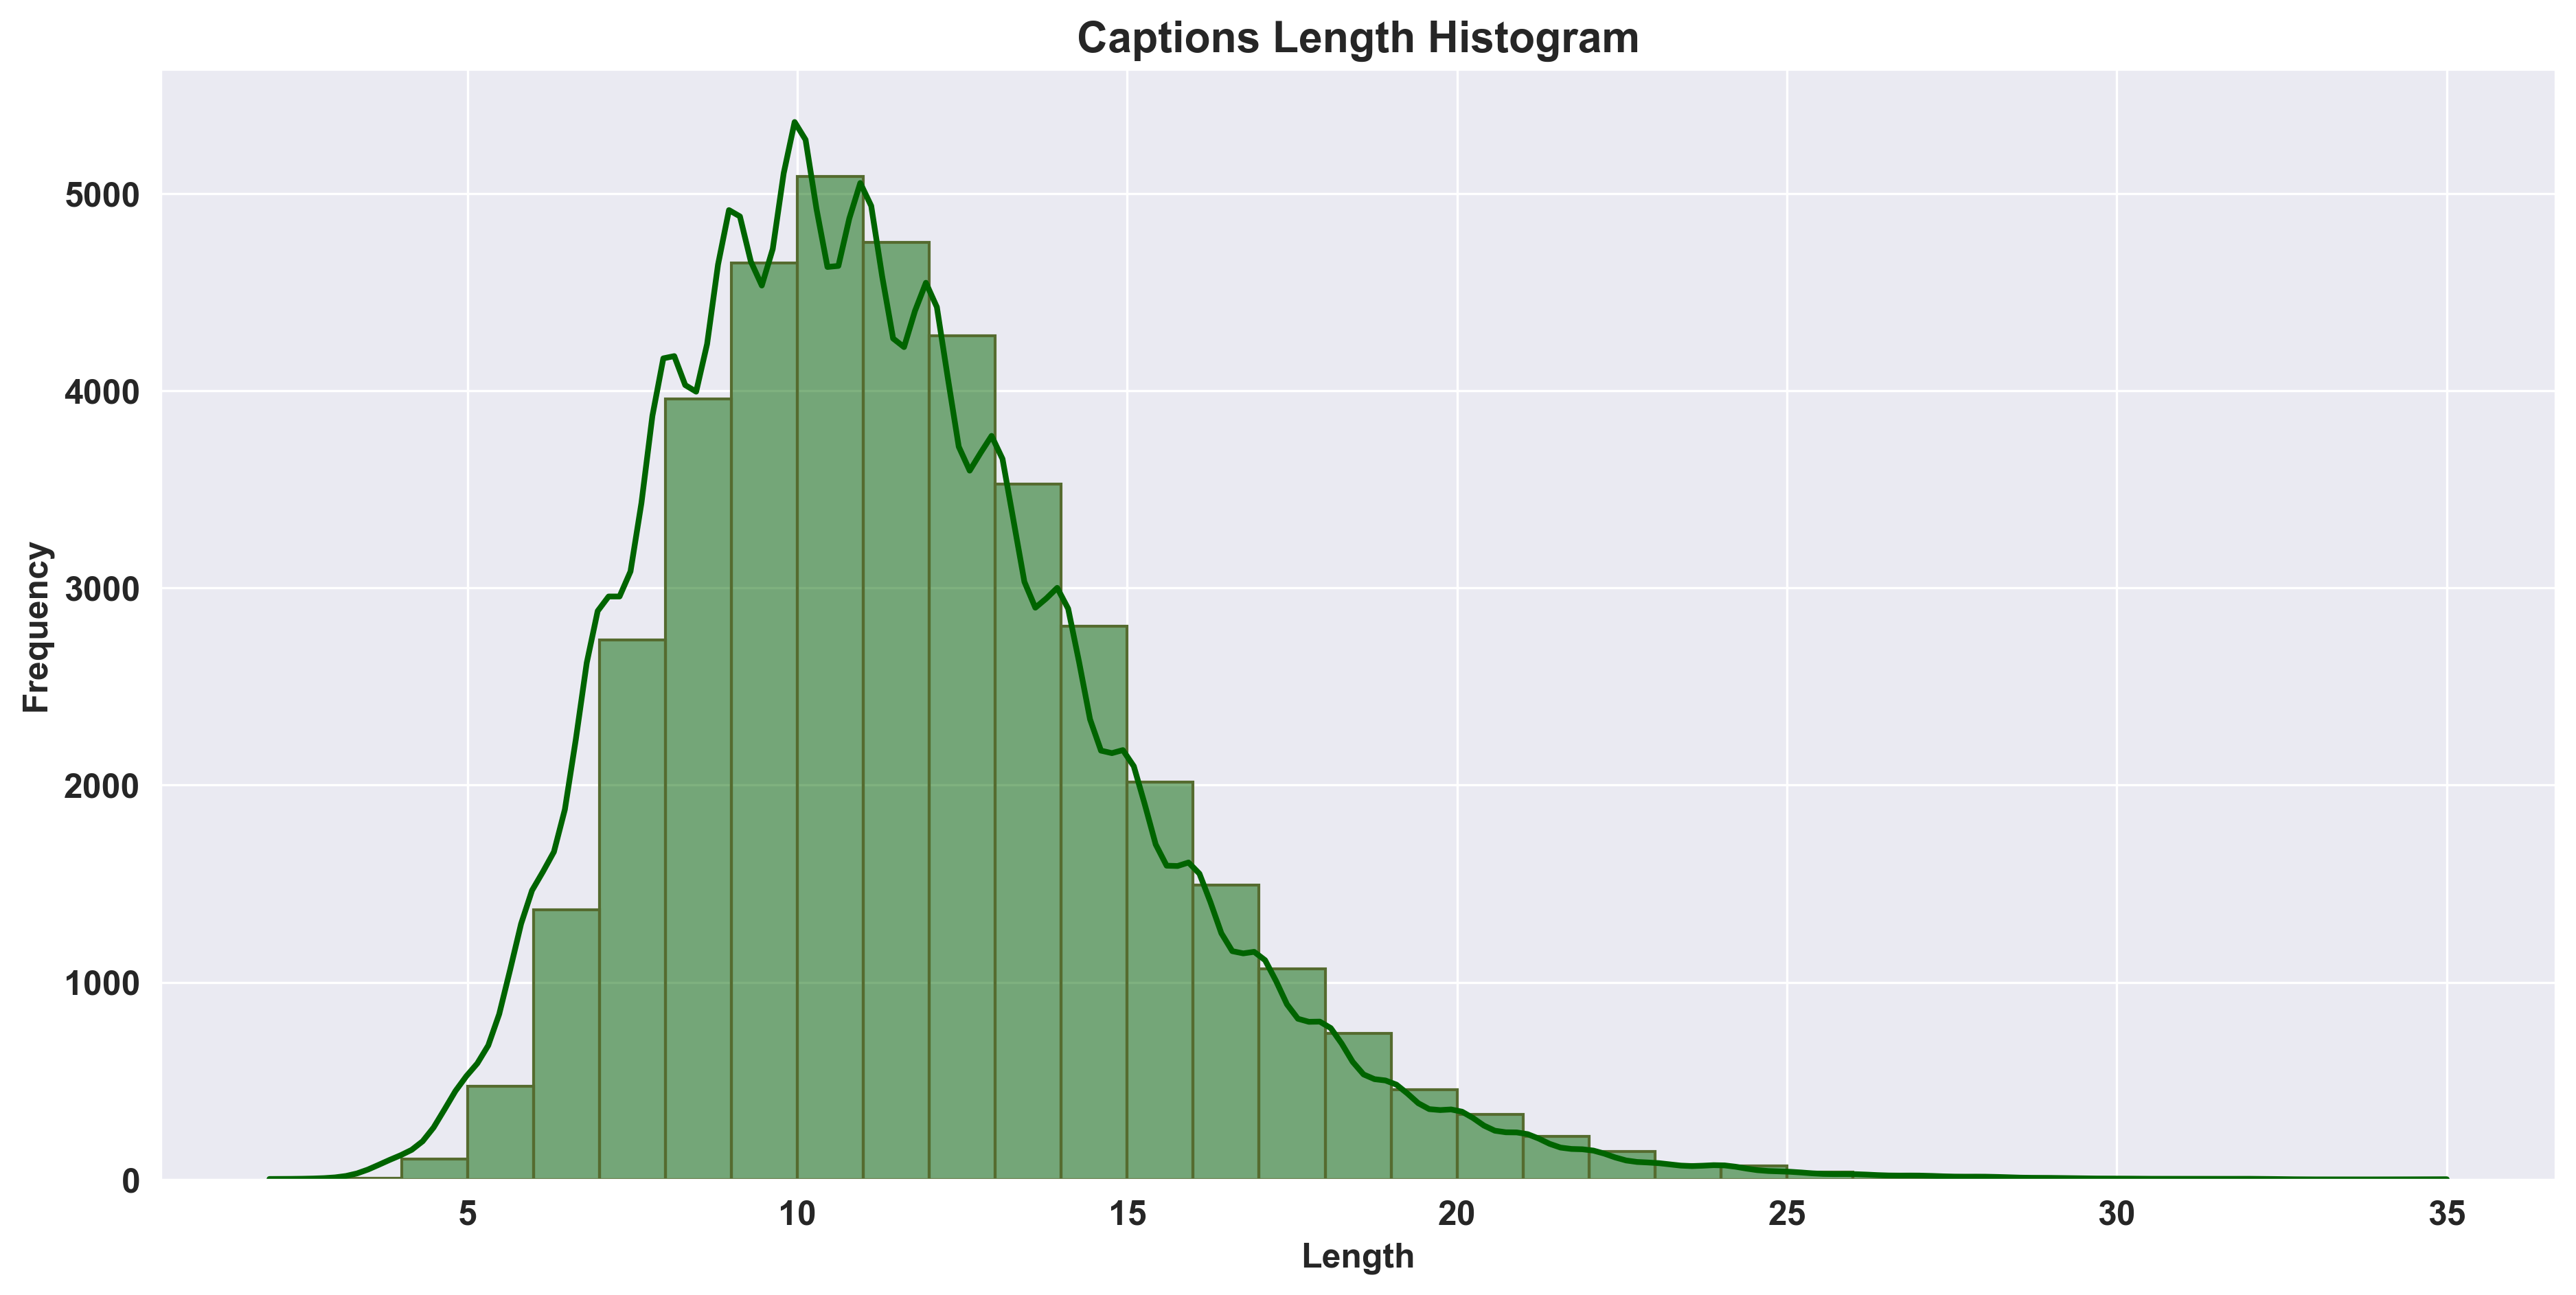

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')

    # Histogram with KDE and separate colors
    sns.histplot(
        x=[len(x.split()) for x in data], 
        kde=True, binwidth=1, 
        color='#006400',  # Olive Green for bars
        edgecolor='#556B2F',  # Dark Olive Green edges
        line_kws={'color': '#90EE90', 'linewidth': 2}  # Dark Green KDE Curve
    )

    # Formatting with Olive Green text
    plt.title('Captions Length Histogram', fontsize=15, fontweight='bold',)
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.xlabel('Length', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')

    plt.show()

captions_length(all_captions)


In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# Assuming `image_ids` contains all available image keys
from sklearn.model_selection import train_test_split

train_keys, val_keys = train_test_split(list(mapping.keys()), test_size=0.2, random_state=42)  # 80% train, 20% val


In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [26]:
print(vocab_size)
print(max_length)

8485
35


In [27]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units
        self.Wa = tf.keras.layers.Dense(units)
        self.Ua = tf.keras.layers.Dense(units)
        self.Va = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query: shape (batch_size, units)
        # values: shape (batch_size, time_steps, units)
        
        # Compute score
        score = self.Va(tf.nn.tanh(self.Wa(query)[:, tf.newaxis, :] + self.Ua(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Apply attention weights
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units
        })
        return config


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
units = 256
# Encoder model
# Encoder model (ResNet50 outputs 2048 features instead of 4096)
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(units, activation='relu')(fe1)
units = 256

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, units)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(units, return_sequences=True)(se2)  # Return sequences for attention

# Attention layer
attention = BahdanauAttention(units)
context_vector, attention_weights = attention(fe2, se3)

# Decoder model
decoder_input = Concatenate(axis=-1)([fe2, context_vector])
decoder1 = Dense(units, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [29]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

In [30]:
import math

# Print dataset size
print(f"Training Samples: {len(train_keys)}")
print(f"Validation Samples: {len(val_keys)}")

# Ensure consistent steps per epoch
steps = math.ceil(len(train_keys) / batch_size)  # Round up to avoid dropping samples
val_steps = math.ceil(len(val_keys) / batch_size)

print(f"Steps per Epoch: {steps}")
print(f"Validation Steps: {val_steps}")


Training Samples: 6472
Validation Samples: 1619
Steps per Epoch: 203
Validation Steps: 51


Loading pre-trained model...
Training complete.


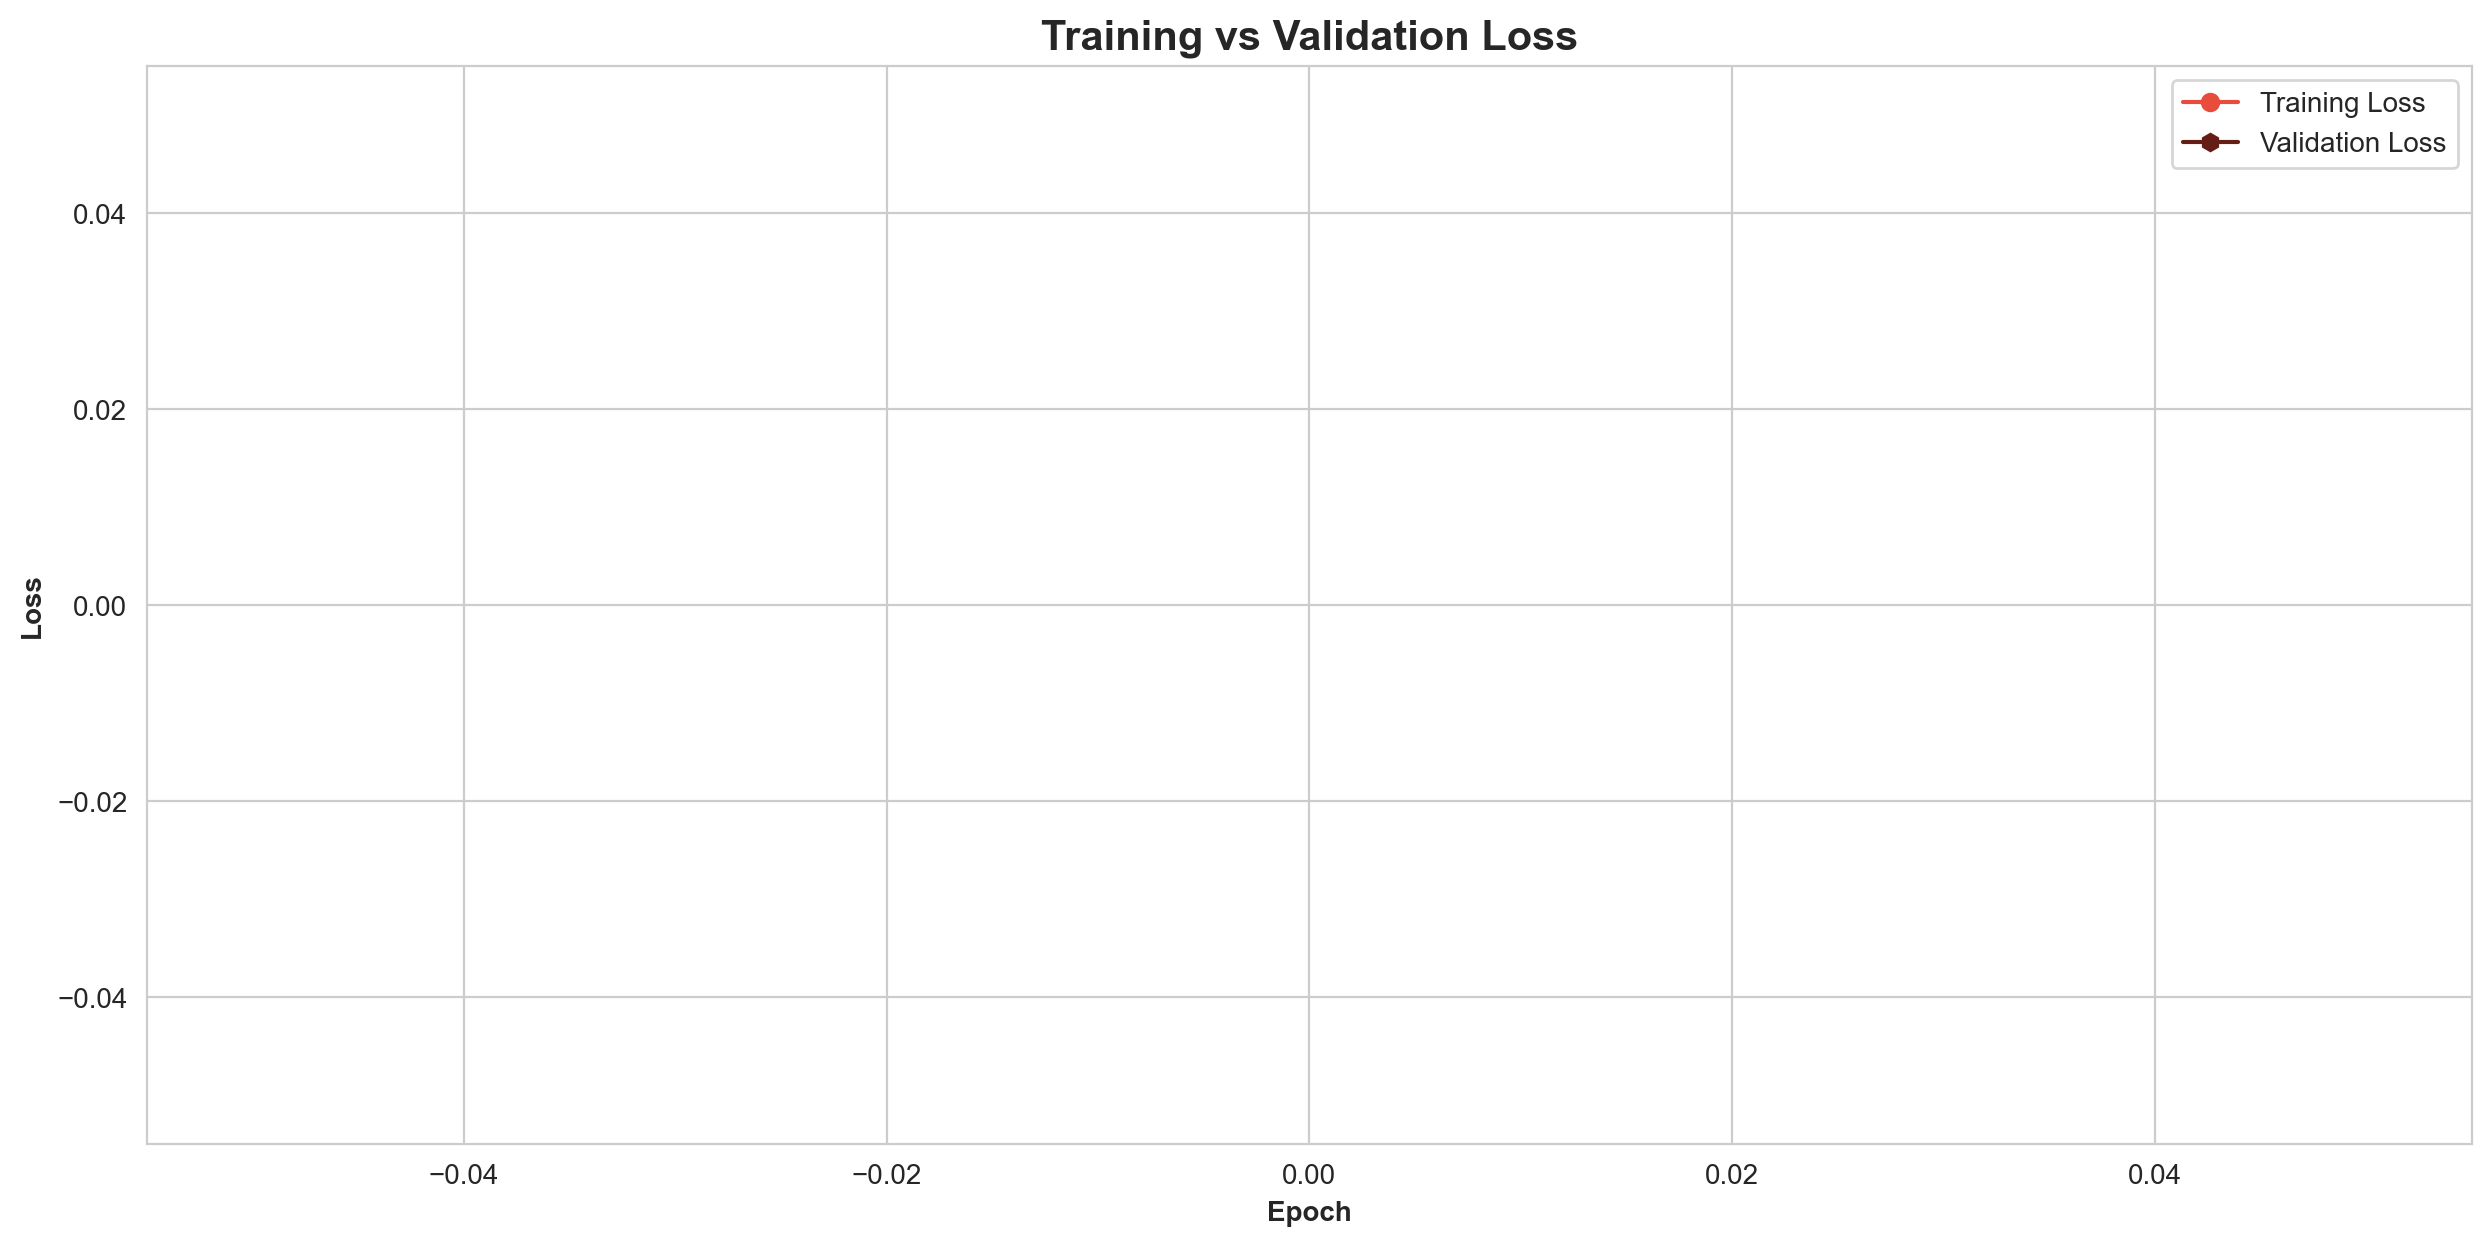

In [31]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

MODEL_PATH = os.path.join(WORKING_DIR, 'best_model_resnet_50_301.h5')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split dataset into train and validation sets
train_keys, val_keys = train_test_split(list(mapping.keys()), test_size=0.2, random_state=42)  # 80% train, 20% val

# Define steps per epoch for training and validation
factor = 1.5  # Increase steps artificially
steps = math.ceil(factor * (len(train_keys) / batch_size))
val_steps = math.ceil(factor * (len(val_keys) / batch_size))

# Initialize history variable
history = {'loss': [], 'val_loss': []}

# Check if a trained model already exists
if os.path.exists(MODEL_PATH):
    print("Loading pre-trained model...")
    model = load_model(MODEL_PATH, custom_objects={"BahdanauAttention": BahdanauAttention})  # Ensure custom layer is loaded

else:
    print("Training the model...")

    for i in range(epochs):
        # Create data generators
        generator = data_generator(train_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        val_generator = data_generator(val_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)

        # Train for one epoch
        epoch_history = model.fit(
            generator,
            validation_data=val_generator,
            epochs=1,
            steps_per_epoch=steps,
            validation_steps=val_steps,  # Now defined
            verbose=1,
            callbacks=[early_stopping]
        )

        # Store losses for plotting
        history['loss'].append(epoch_history.history['loss'][0])
        history['val_loss'].append(epoch_history.history['val_loss'][0])

        # Save the model after each epoch
        model.save(MODEL_PATH)
        print(f"Model saved after epoch {i+1}")

print("Training complete.")

# Plot Training vs Validation Loss
if history and 'loss' in history and 'val_loss' in history:
    plt.figure(figsize=(15, 7), dpi=200)
    sns.set_style('whitegrid')

    plt.plot(range(1, len(history['loss']) + 1), history['loss'], color='#E74C3C', marker='o', linestyle='-')
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], color='#641E16', marker='h', linestyle='-')

    plt.title('Training vs Validation Loss', fontsize=15, fontweight='bold')
    plt.xlabel('Epoch', fontweight='bold')
    plt.ylabel('Loss', fontweight='bold')
    plt.legend(['Training Loss', 'Validation Loss'], loc='best')

    plt.show()
else:
    print("No training history found. Model was loaded from a file, so loss plot cannot be generated.")


In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
captions_length(list(generated_captions.values()))

In [37]:
BLEU_SCORES_PATH = os.path.join(WORKING_DIR, 'bleu_scores_resnet50_301.pkl')

# Check if BLEU scores already exist
if os.path.exists(BLEU_SCORES_PATH):
    print("Loading precomputed BLEU scores...")
    with open(BLEU_SCORES_PATH, 'rb') as f:
        bleu_scores = pickle.load(f)
    
    print(f"BLEU-1: {bleu_scores['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['BLEU-2']:.6f}")

else:
    print("Calculating BLEU scores...")
    
    from nltk.translate.bleu_score import corpus_bleu
    actual, predicted = list(), list()

    for key in tqdm(test):
        # Get actual captions
        captions = mapping[key]
        # Predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length) 
        # Split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # Append to lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # Calculate BLEU scores
    bleu_scores = {
        "BLEU-1": corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
        "BLEU-2": corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    }

    print(f"BLEU-1: {bleu_scores['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['BLEU-2']:.6f}")

    # Save BLEU scores to a file
    with open(BLEU_SCORES_PATH, 'wb') as f:
        pickle.dump(bleu_scores, f)


Loading precomputed BLEU scores...
BLEU-1: 0.609073
BLEU-2: 0.408439


Loading precomputed actual caption lengths...
Loading precomputed generated caption lengths...


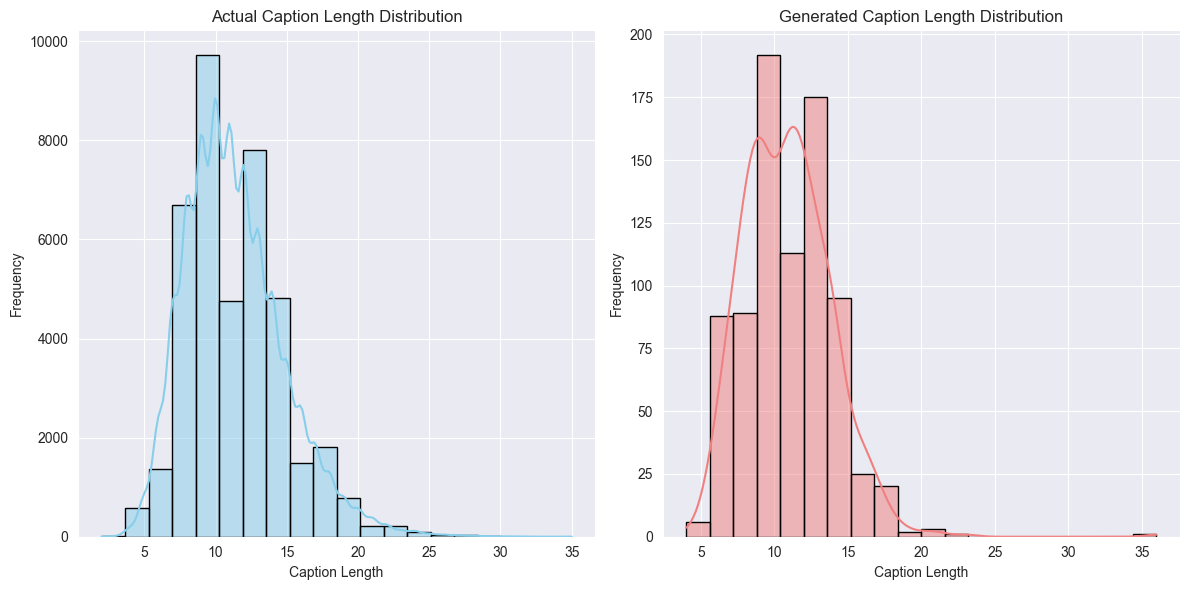

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

ACTUAL_CAPTION_LENGTHS_PATH = os.path.join(WORKING_DIR, 'actual_caption_lengths.pkl')
GENERATED_CAPTION_LENGTHS_PATH = os.path.join(WORKING_DIR, 'generated_caption_lengths.pkl')

# Load or compute actual caption lengths
if os.path.exists(ACTUAL_CAPTION_LENGTHS_PATH):
    print("Loading precomputed actual caption lengths...")
    with open(ACTUAL_CAPTION_LENGTHS_PATH, 'rb') as f:
        actual_caption_lengths = pickle.load(f)
else:
    print("Computing actual caption lengths...")
    actual_caption_lengths = [len(caption.split()) for captions in mapping.values() for caption in captions]
    
    # Save computed lengths
    with open(ACTUAL_CAPTION_LENGTHS_PATH, 'wb') as f:
        pickle.dump(actual_caption_lengths, f)

# Load or compute generated caption lengths
if os.path.exists(GENERATED_CAPTION_LENGTHS_PATH):
    print("Loading precomputed generated caption lengths...")
    with open(GENERATED_CAPTION_LENGTHS_PATH, 'rb') as f:
        generated_caption_lengths = pickle.load(f)
else:
    print("Computing generated caption lengths...")
    generated_caption_lengths = []
    
    for key in tqdm(test):
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        generated_caption_lengths.append(len(y_pred.split()))
    
    # Save computed lengths
    with open(GENERATED_CAPTION_LENGTHS_PATH, 'wb') as f:
        pickle.dump(generated_caption_lengths, f)

# Set Seaborn style
sns.set_style('darkgrid')

# Plot both histograms
plt.figure(figsize=(12, 6))

# Actual Captions Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(actual_caption_lengths, bins=20, color='skyblue', edgecolor='black', kde=True)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Actual Caption Length Distribution')

# Generated Captions Histogram with KDE
plt.subplot(1, 2, 2)
sns.histplot(generated_caption_lengths, bins=20, color='lightcoral', edgecolor='black', kde=True)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Generated Caption Length Distribution')

# Adjust layout
plt.tight_layout()
plt.show()




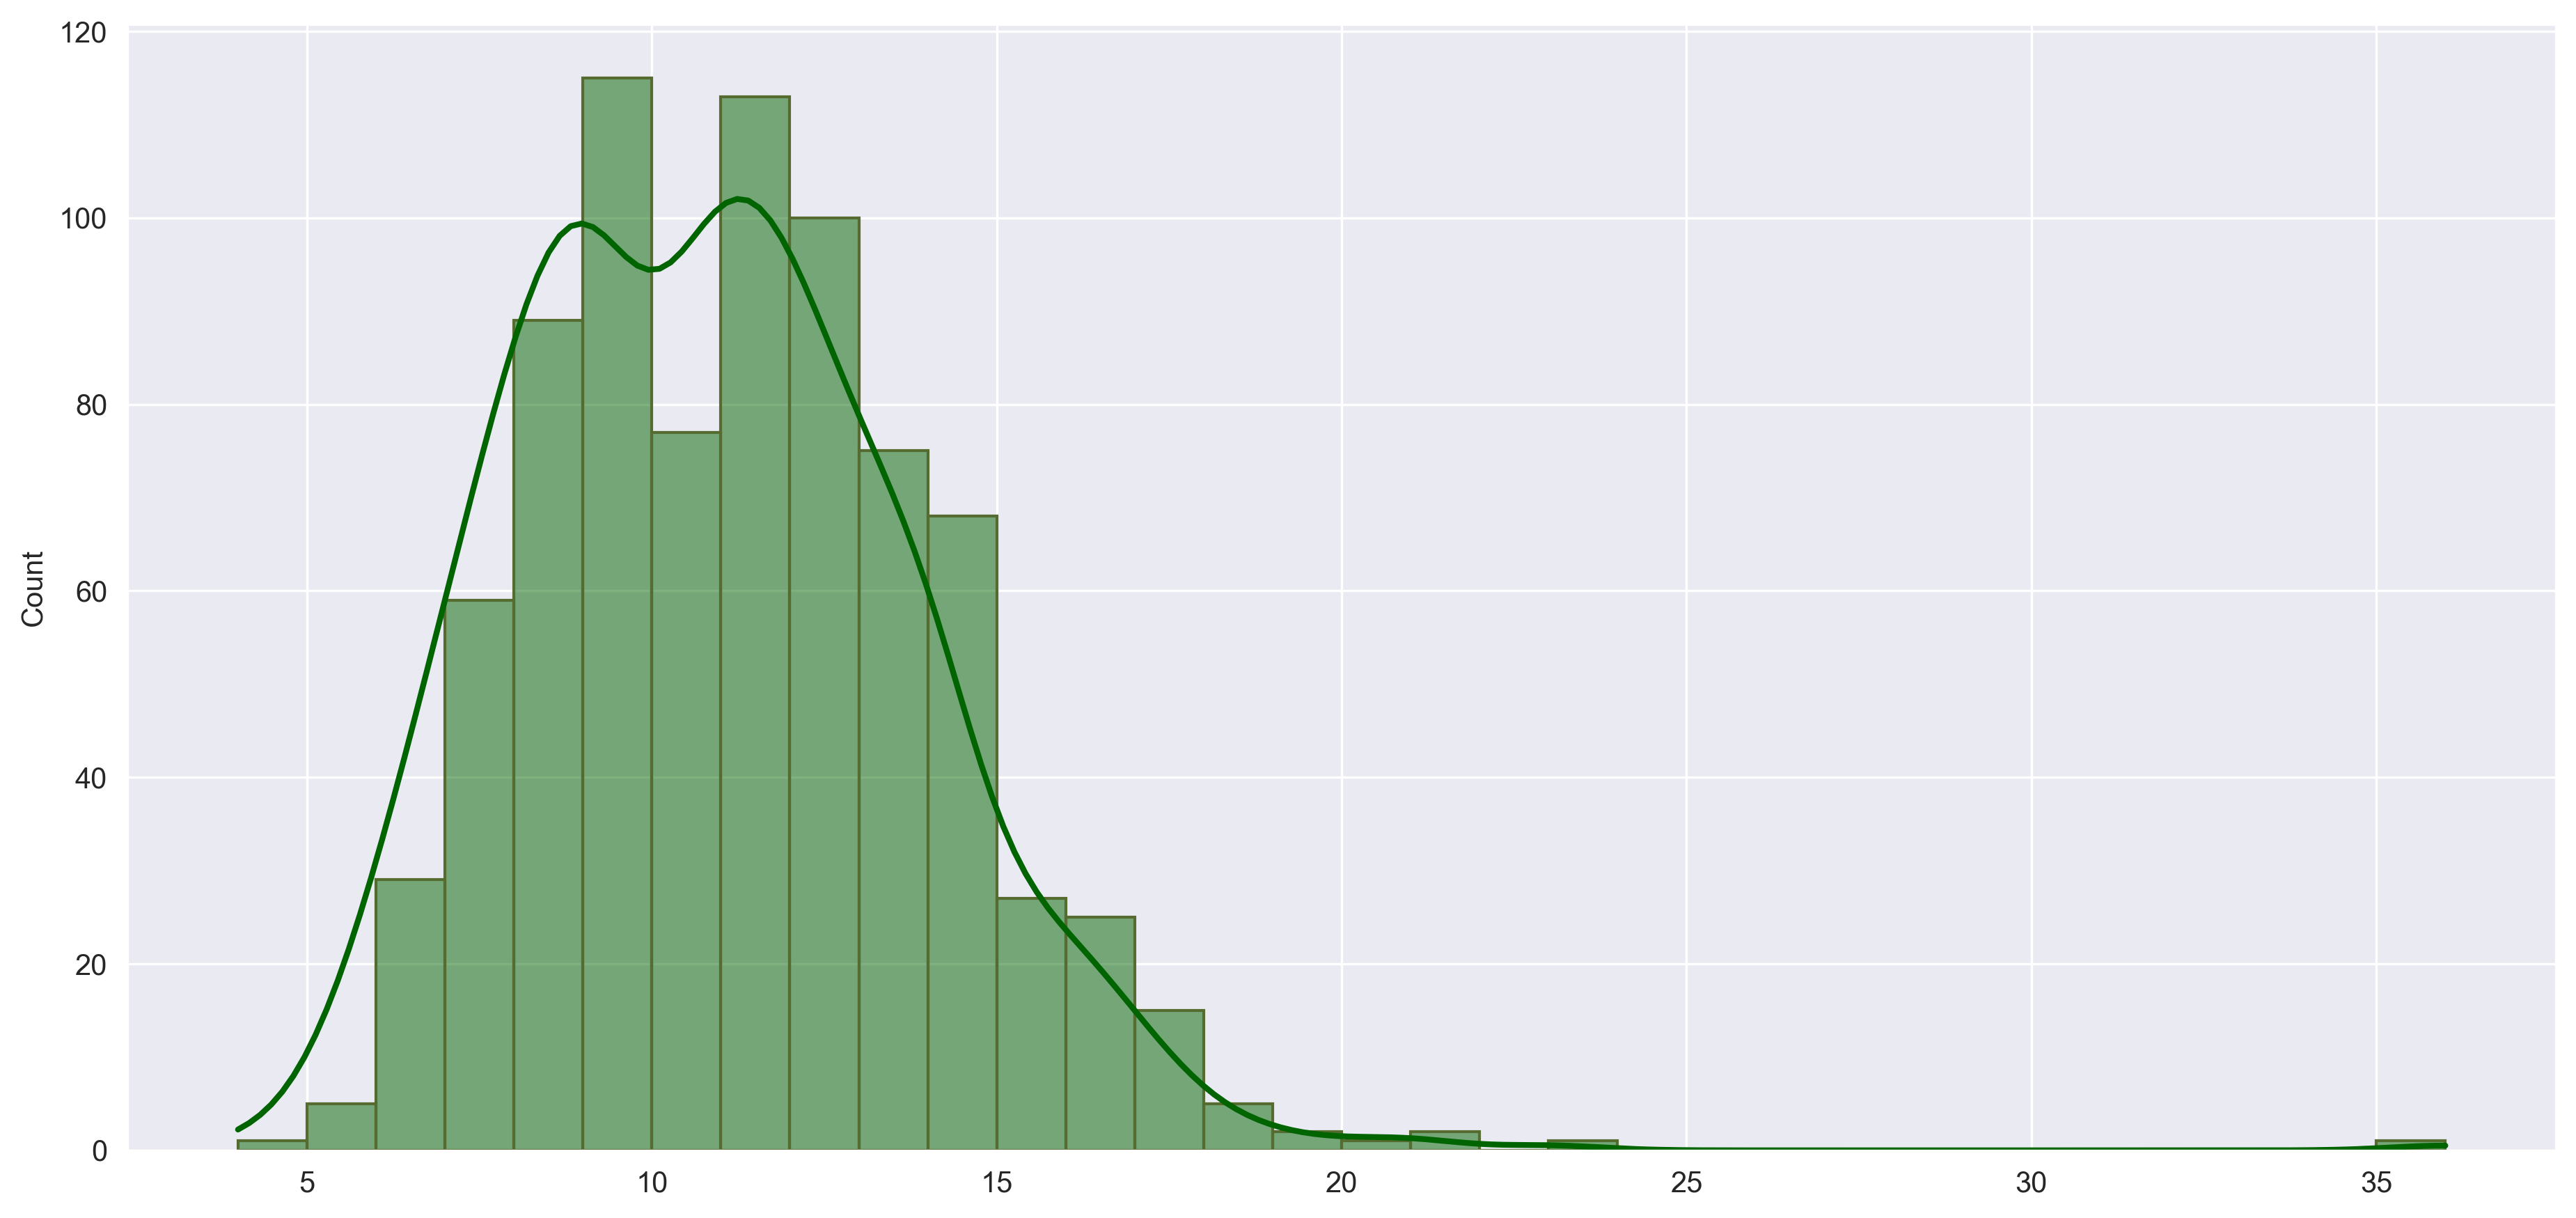

"import matplotlib.pyplot as plt\nimport seaborn as sns\n\ndef captions_length(data):\n    plt.figure(figsize=(15, 7), dpi=300)\n    sns.set_style('darkgrid')\n\n    # Histogram with KDE and separate colors\n    sns.histplot(\n        x=[len(x.split()) for x in data], \n        kde=True, binwidth=1, \n        color='#006400',  # Olive Green for bars\n        edgecolor='#556B2F',  # Dark Olive Green edges\n        line_kws={'color': '#90EE90', 'linewidth': 2}  # Dark Green KDE Curve\n    )\n\n\n\n    plt.show()\n    # Formatting with Olive Green text\n    plt.title('Captions Length Histogram', fontsize=15, fontweight='bold',)\n    plt.xticks(fontsize=12, fontweight='bold')\n    plt.yticks(fontsize=12, fontweight='bold')\n    plt.xlabel('Length', fontsize=12, fontweight='bold')\n    plt.ylabel('Frequency', fontsize=12, fontweight='bold')\ncaptions_length(all_captions)"

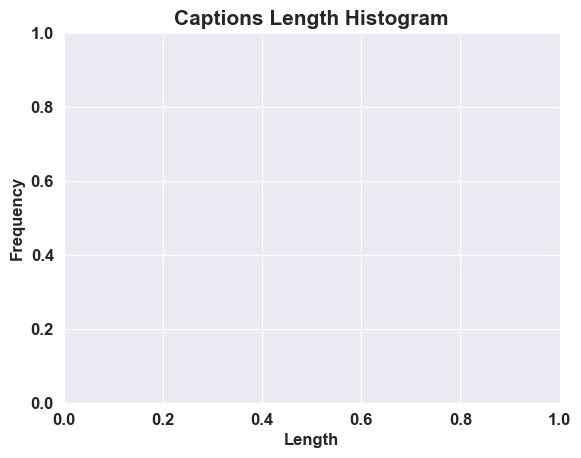

In [64]:
# Generated Captions Histogram with KDE
#plt.subplot(1, 2, 2)
plt.figure(figsize=(15, 7), dpi=300)
sns.set_style('darkgrid')
sns.histplot(generated_caption_lengths,kde=True, binwidth=1, 
        color='#006400',  # Olive Green for bars
        edgecolor='#556B2F',  # Dark Olive Green edges
        line_kws={'color': '#90EE90', 'linewidth': 2})
plt.show()
    # Formatting with Olive Green text
plt.title('Captions Length Histogram', fontsize=15, fontweight='bold',)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel('Length', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
'''import matplotlib.pyplot as plt
import seaborn as sns

def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')

    # Histogram with KDE and separate colors
    sns.histplot(
        x=[len(x.split()) for x in data], 
        kde=True, binwidth=1, 
        color='#006400',  # Olive Green for bars
        edgecolor='#556B2F',  # Dark Olive Green edges
        line_kws={'color': '#90EE90', 'linewidth': 2}  # Dark Green KDE Curve
    )



    plt.show()
    # Formatting with Olive Green text
    plt.title('Captions Length Histogram', fontsize=15, fontweight='bold',)
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.xlabel('Length', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
captions_length(all_captions)'''


In [39]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

AttributeError: 'function' object has no attribute 'values'

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is fighting with white and white dog endseq


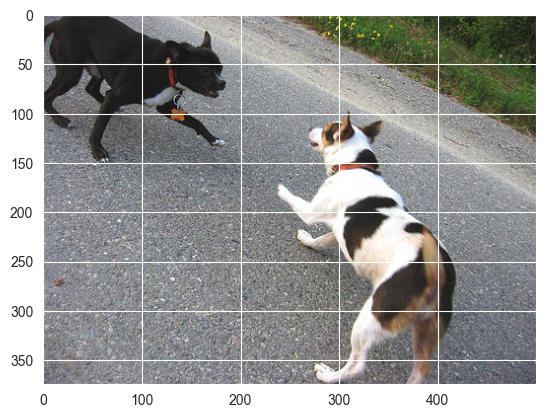

In [40]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is playing with bubbles in the snow endseq


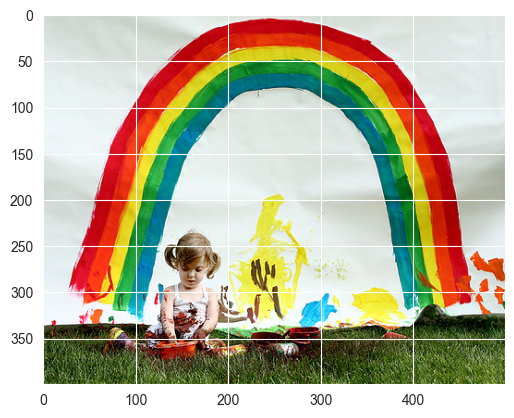

In [41]:
generate_caption("1002674143_1b742ab4b8.jpg")

In [42]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_model.output)

image_path = 'C:/Users/User/PycharmProjects/Captioning/venv/000000000036.jpg'
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Extract features
feature = resnet_model.predict(image, verbose=0)

# Predict caption
predict_caption(model, feature, tokenizer, max_length)


'startseq girl in pink dress is swinging her head in her hand endseq'

In [43]:
def predict_caption_greedy(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)  # Select word with highest probability
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


In [44]:
def predict_caption_beam_search(model, image, tokenizer, max_length, beam_width=3):
    sequences = [('startseq', 0)]  # (sequence, log probability)

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            # Stop if "endseq" is already generated
            if seq.split()[-1] == 'endseq':
                all_candidates.append((seq, score))
                continue

            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], max_length)
            yhat = model.predict([image, sequence], verbose=0)[0]

            # Get the top-k words and their probabilities
            top_k = np.argsort(yhat)[-beam_width:]  # Get k highest probability words
            
            for word_idx in top_k:
                word = idx_to_word(word_idx, tokenizer)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(yhat[word_idx])  # Log sum to avoid probability underflow
                all_candidates.append((new_seq, new_score))

        # Sort by highest probability and keep top k sequences
        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    # Return best sequence, but remove duplicate "endseq"
    best_seq = sequences[0][0]
    best_seq = best_seq.split()
    
    if "endseq" in best_seq:
        best_seq = best_seq[:best_seq.index("endseq")+1]  # Keep only first "endseq"

    return " ".join(best_seq)


In [45]:
def generate_caption(image_name, beam_width=3):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    
    print('---------------------Actual---------------------')
    for caption in mapping[image_id]:
        print(caption)
    
    print('--------------------Greedy Prediction--------------------')
    print(predict_caption_greedy(model, features[image_id], tokenizer, max_length))
    
    print(f'--------------------Beam Search Prediction (k={beam_width})--------------------')
    print(predict_caption_beam_search(model, features[image_id], tokenizer, max_length, beam_width))
    
    plt.imshow(image)


---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Greedy Prediction--------------------
startseq little girl is playing with bubbles in the snow endseq
--------------------Beam Search Prediction (k=9)--------------------
startseq little girl is playing with bubbles in the snow endseq


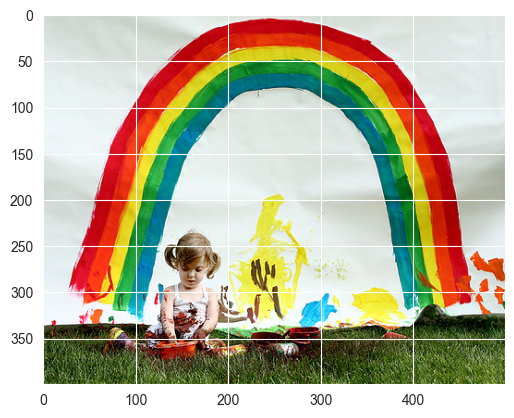

In [46]:
generate_caption("1002674143_1b742ab4b8.jpg", beam_width=9)


In [47]:
from nltk.translate.bleu_score import corpus_bleu
import pickle

BLEU_SCORES_PATH = os.path.join(WORKING_DIR, 'bleu_scores_resnet504.pkl')

# Check if BLEU scores already exist
if os.path.exists(BLEU_SCORES_PATH):
    print("Loading precomputed BLEU scores...")
    with open(BLEU_SCORES_PATH, 'rb') as f:
        bleu_scores = pickle.load(f)

    print("Greedy Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Greedy']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Greedy']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Greedy']['BLEU-4']:.6f}\n")

    print("Beam Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Beam']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Beam']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Beam']['BLEU-4']:.6f}")

else:
    print("Calculating BLEU scores...")

    actual, greedy_pred, beam_pred = [], [], []

    for key in tqdm(test):
        # Get actual captions
        captions = mapping[key]
        actual_captions = [caption.split() for caption in captions]

        # Generate captions using Greedy and Beam Search
        y_pred_greedy = predict_caption_greedy(model, features[key], tokenizer, max_length).split()
        y_pred_beam = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width=3).split()

        # Append to lists
        actual.append(actual_captions)
        greedy_pred.append(y_pred_greedy)
        beam_pred.append(y_pred_beam)

    # Calculate BLEU scores separately
    bleu_scores = {
        "Greedy": {
            "BLEU-1": corpus_bleu(actual, greedy_pred, weights=(1.0, 0, 0, 0)),
            "BLEU-2": corpus_bleu(actual, greedy_pred, weights=(0.5, 0.5, 0, 0)),
            "BLEU-4": corpus_bleu(actual, greedy_pred, weights=(0.25, 0.25, 0.25, 0.25)),
        },
        "Beam": {
            "BLEU-1": corpus_bleu(actual, beam_pred, weights=(1.0, 0, 0, 0)),
            "BLEU-2": corpus_bleu(actual, beam_pred, weights=(0.5, 0.5, 0, 0)),
            "BLEU-4": corpus_bleu(actual, beam_pred, weights=(0.25, 0.25, 0.25, 0.25)),
        }
    }

    print("Greedy Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Greedy']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Greedy']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Greedy']['BLEU-4']:.6f}\n")

    print("Beam Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Beam']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Beam']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Beam']['BLEU-4']:.6f}")

    # Save BLEU scores to a file
    with open(BLEU_SCORES_PATH, 'wb') as f:
        pickle.dump(bleu_scores, f)


Loading precomputed BLEU scores...
Greedy Search BLEU Scores:
BLEU-1: 0.670109
BLEU-2: 0.499957
BLEU-4: 0.312642

Beam Search BLEU Scores:
BLEU-1: 0.721483
BLEU-2: 0.568827
BLEU-4: 0.392774


Loading precomputed BLEU scores...
Greedy Search BLEU Scores:
BLEU-1: 0.670109
BLEU-2: 0.499957
BLEU-4: 0.312642

Beam Search BLEU Scores:
BLEU-1: 0.721483
BLEU-2: 0.568827
BLEU-4: 0.392774


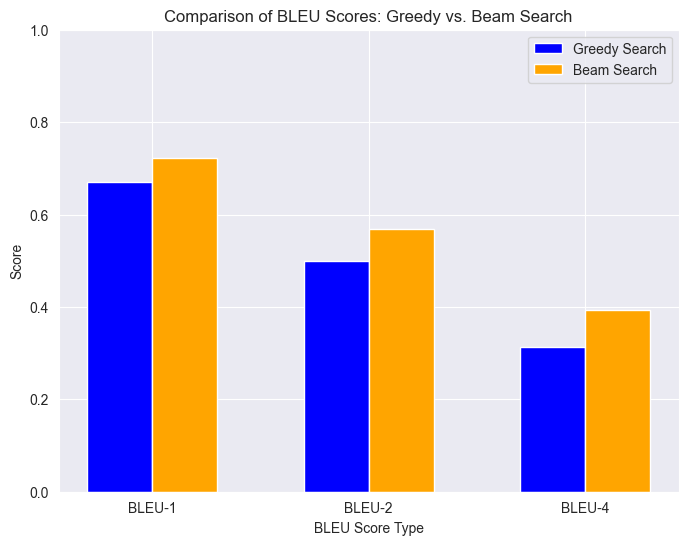

In [48]:
from nltk.translate.bleu_score import corpus_bleu
import pickle
import matplotlib.pyplot as plt
import numpy as np

BLEU_SCORES_PATH = os.path.join(WORKING_DIR, 'bleu_scores_resnet504.pkl')

# Check if BLEU scores already exist
if os.path.exists(BLEU_SCORES_PATH):
    print("Loading precomputed BLEU scores...")
    with open(BLEU_SCORES_PATH, 'rb') as f:
        bleu_scores = pickle.load(f)

    print("Greedy Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Greedy']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Greedy']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Greedy']['BLEU-4']:.6f}\n")

    print("Beam Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Beam']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Beam']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Beam']['BLEU-4']:.6f}")

else:
    print("Calculating BLEU scores...")

    actual, greedy_pred, beam_pred = [], [], []

    for key in tqdm(test):
        # Get actual captions
        captions = mapping[key]
        actual_captions = [caption.split() for caption in captions]

        # Generate captions using Greedy and Beam Search
        y_pred_greedy = predict_caption_greedy(model, features[key], tokenizer, max_length).split()
        y_pred_beam = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width=3).split()

        # Append to lists
        actual.append(actual_captions)
        greedy_pred.append(y_pred_greedy)
        beam_pred.append(y_pred_beam)

    # Calculate BLEU scores separately
    bleu_scores = {
        "Greedy": {
            "BLEU-1": corpus_bleu(actual, greedy_pred, weights=(1.0, 0, 0, 0)),
            "BLEU-2": corpus_bleu(actual, greedy_pred, weights=(0.5, 0.5, 0, 0)),
            "BLEU-4": corpus_bleu(actual, greedy_pred, weights=(0.25, 0.25, 0.25, 0.25)),
        },
        "Beam": {
            "BLEU-1": corpus_bleu(actual, beam_pred, weights=(1.0, 0, 0, 0)),
            "BLEU-2": corpus_bleu(actual, beam_pred, weights=(0.5, 0.5, 0, 0)),
            "BLEU-4": corpus_bleu(actual, beam_pred, weights=(0.25, 0.25, 0.25, 0.25)),
        }
    }

    print("Greedy Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Greedy']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Greedy']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Greedy']['BLEU-4']:.6f}\n")

    print("Beam Search BLEU Scores:")
    print(f"BLEU-1: {bleu_scores['Beam']['BLEU-1']:.6f}")
    print(f"BLEU-2: {bleu_scores['Beam']['BLEU-2']:.6f}")
    print(f"BLEU-4: {bleu_scores['Beam']['BLEU-4']:.6f}")

    # Save BLEU scores to a file
    with open(BLEU_SCORES_PATH, 'wb') as f:
        pickle.dump(bleu_scores, f)

#  Plot Comparative Bar Graph
categories = ['BLEU-1', 'BLEU-2', 'BLEU-4']
greedy_scores = [bleu_scores['Greedy'][key] for key in categories]
beam_scores = [bleu_scores['Beam'][key] for key in categories]

bar_width = 0.3
x = np.arange(len(categories))

plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, greedy_scores, bar_width, label='Greedy Search', color='blue')
plt.bar(x + bar_width/2, beam_scores, bar_width, label='Beam Search', color='orange')

plt.xlabel("BLEU Score Type")
plt.ylabel("Score")
plt.title("Comparison of BLEU Scores: Greedy vs. Beam Search")
plt.xticks(ticks=x, labels=categories)
plt.ylim(0, 1)  # BLEU scores are between 0 and 1
plt.legend()
plt.show()


In [49]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_bleu_for_custom_image(image_path, model, resnet_model, tokenizer, max_length, mapping, manual_captions=None):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

    # Use smoothing function
    smooth = SmoothingFunction().method1  

    # Load and preprocess image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features
    feature = resnet_model.predict(image, verbose=0)

    # Predict captions using both Greedy and Beam Search
    predicted_caption_greedy = predict_caption_greedy(model, feature, tokenizer, max_length).split()
    predicted_caption_beam = predict_caption_beam_search(model, feature, tokenizer, max_length, beam_width=3).split()

    # Get actual captions from mapping or use manual captions
    image_name = image_path.split('/')[-1]  # Extract file name
    image_id = image_name.split('.')[0]

    if image_id in mapping:
        actual_captions = [caption.split() for caption in mapping[image_id]]  
    elif manual_captions:  
        actual_captions = [caption.split() for caption in manual_captions]
    else:
        print(" No ground truth captions found for this image. Cannot compute BLEU score.")
        return

    # Compute BLEU scores with smoothing
    bleu_scores = {
        "Greedy": {
            "BLEU-1": sentence_bleu(actual_captions, predicted_caption_greedy, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
            "BLEU-2": sentence_bleu(actual_captions, predicted_caption_greedy, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
            "BLEU-4": sentence_bleu(actual_captions, predicted_caption_greedy, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
        },
        "Beam": {
            "BLEU-1": sentence_bleu(actual_captions, predicted_caption_beam, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
            "BLEU-2": sentence_bleu(actual_captions, predicted_caption_beam, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
            "BLEU-4": sentence_bleu(actual_captions, predicted_caption_beam, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
        }
    }

    # Print results
    print("\n **Custom Image BLEU Scores (With Smoothing)**")
    print(f" **Greedy Search**: BLEU-1: {bleu_scores['Greedy']['BLEU-1']:.6f}, "
          f"BLEU-2: {bleu_scores['Greedy']['BLEU-2']:.6f}, "
          f"BLEU-4: {bleu_scores['Greedy']['BLEU-4']:.6f}")

    print(f" **Beam Search**: BLEU-1: {bleu_scores['Beam']['BLEU-1']:.6f}, "
          f"BLEU-2: {bleu_scores['Beam']['BLEU-2']:.6f}, "
          f"BLEU-4: {bleu_scores['Beam']['BLEU-4']:.6f}")

    #  Plot Comparative Bar Graph
    categories = ['BLEU-1', 'BLEU-2', 'BLEU-4']
    greedy_scores = [bleu_scores['Greedy'][key] for key in categories]
    beam_scores = [bleu_scores['Beam'][key] for key in categories]

    bar_width = 0.3
    x = np.arange(len(categories))

    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width/2, greedy_scores, bar_width, label='Greedy Search', color='blue')
    plt.bar(x + bar_width/2, beam_scores, bar_width, label='Beam Search', color='orange')

    plt.xlabel("BLEU Score Type")
    plt.ylabel("Score")
    plt.title("Comparison of BLEU Scores: Greedy vs. Beam Search (Custom Image)")
    plt.xticks(ticks=x, labels=categories)
    plt.ylim(0, 1)  
    plt.legend()
    plt.show()

    return bleu_scores


In [ ]:
# Load and preprocess the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Extract image features using ResNet50
feature = resnet_model.predict(image, verbose=0)

# Generate the predicted caption
predicted_caption = predict_caption(model, feature, tokenizer, max_length)

# Print the actual manual captions
print(" Actual Captions:")
for caption in manual_captions:
    print(f"- {caption}")

# Print the predicted caption
print("\n Predicted Caption:")
print(predicted_caption)

# Compute BLEU score
custom_bleu_scores = calculate_bleu_for_custom_image(image_path, model, resnet_model, tokenizer, max_length, mapping, manual_captions)


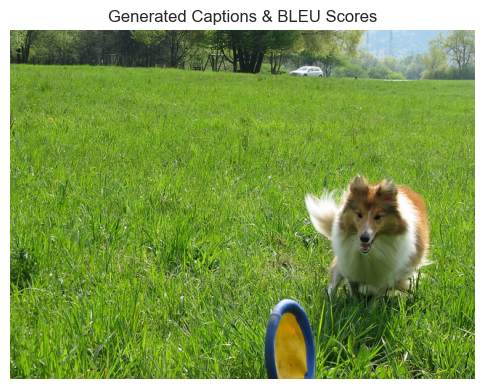

In [74]:
import matplotlib.pyplot as plt
import PIL.Image

# Load the image
image_path = "C:/Users/User/PycharmProjects/Captioning/venv/000000000307.jpg"
image = PIL.Image.open(image_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.title("Generated Captions & BLEU Scores")
plt.show()


In [ ]:
image_path = 'C:/Users/User/PycharmProjects/Captioning/venv/000000000307.jpg'

# Manually provide reference captions (describe the image yourself)
manual_captions = [ "The dog is playing with his toy in the grass.", "A dog that is standing in the grass near a frisbee.", "A collie chasing a frisbee in the grass.", "A cute dog is in the grass with a frisbee.", "A brown and white dog chasing a blue and yellow frisbee." ]

# Compute BLEU score for the custom image
custom_bleu_scores = calculate_bleu_for_custom_image(image_path, model, resnet_model, tokenizer, max_length, mapping, manual_captions)


In [ ]:
image_path = 'C:/Users/User/PycharmProjects/Captioning/venv/000000000036.jpg'

# Manually provide reference captions (describe the image yourself)
manual_captions = [ "Woman in swimsuit holding parasol on a sunny day.", "A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a lifeguard stand with a lake, green trees, and a blue sky with a few clouds behind.", "A woman in a floral swimsuit holds a pink umbrella.", "A woman with an umbrella near the sea.", "A girl in a bathing suit with a pink umbrella." ]

# Compute BLEU score for the custom image
custom_bleu_scores = calculate_bleu_for_custom_image(image_path, model, resnet_model, tokenizer, max_length, mapping, manual_captions)


In [ ]:
image_path = 'C:/Users/User/PycharmProjects/Captioning/venv/000000001966.jpg'

# Manually provide reference captions (describe the image yourself)
manual_captions = [ "A man leaning over as he gets ready to serve a ball.",  

"A man using a tennis racket on a court.",  

"A man with a tennis racket and ball getting ready to hit it.",  

"Player preparing to serve ball during tennis match.",  

"The young man tennis player is ready to serve the ball."  
 ]

# Compute BLEU score for the custom image
custom_bleu_scores = calculate_bleu_for_custom_image(image_path, model, resnet_model, tokenizer, max_length, mapping, manual_captions)
